In [75]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc


%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size



####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )[500:3900]
Temperature_d=(data.T)[0]
dof_d=(data.T)[1]#relativistic degrees of freedom  
dof_s=(data.T)[3]#entropic degrees of freedom
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')
g_star_s = interpolate.interp1d(Temperature_d, dof_s, kind='cubic')


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2

    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot

    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys

    def old_boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]


        #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys


    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        dof = np.array([12])
        return M, dof, Mphys


    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.

        return [np.array([v,self.u])]

    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and abs(self.lammix)<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False


    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")

    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0.
        Doesn't work for Z_2 symmetric potential!!!"""
        n=100
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            print("Model has a Z2 symmetry in the potential \n")
            print("isEWSB=True \n")
            return True
        #------------
        X0=self.findMinimum([0,100],0)
        if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
        X0=self.findMinimum([0,-100],0)
        if m.Vtot(X0,0)<=m.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
         
        ###This loop search for a global minima randomly
        for i in range(n):
            x1=np.random.uniform(-100,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(X0[0])-v>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1e2:
                print("Global minimum found at X=",X0,"\n")
                print("isEWSB=False \n")
                return False
        print("isEWSB=True \n")
        return True




def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum
    ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity


def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restored at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"

    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR

def beta_GW(Tnuc,dS_TdT):
    ###This code defines the parameter beta relevant for stochastic GW spectrum
    beta=Tnuc*dS_TdT
    return beta

def S_profile(T,elem):
    """This function calculates the Euclidean action from a model m at temperature T
    after knowing its phase history. If more than one FOPT is found it uses "elem" from the list. 
    """
    profile=elem["instanton"].profile1D
    alpha_ode=2
    temp=T
    r, phi, dphi, phivector = profile.R, profile.Phi, profile.dPhi, elem["instanton"].Phi
    phi_meta=elem["high_vev"]
    # Find the area of an n-sphere (alpha=n):
    d = alpha_ode+1  # Number of dimensions in the integration
    area = r**alpha_ode * 2*np.pi**(d*.5)/special.gamma(d*.5) ##4 pi r^2 the surface of a sphere
    # And integrate the profile
    integrand = 0.5 * dphi**2 + m.Vtot(phivector,temp) - m.Vtot(phi_meta,temp)
    integrand *= area
    S = integrate.simps(integrand, r)
    # Find the bulk term in the bubble interior
    volume = r[0]**d * np.pi**(d*.5)/special.gamma(d*.5 + 1)
    S += volume * (m.Vtot(phivector[0],temp) - m.Vtot(phi_meta,temp))

    return S/T

#####
def my_getPhases(m):
    myexps=[(-5,-3),(-5,-5),(-5,-4),(-3,-3)]
    for nord in myexps:
        print("doing",nord)
        try:
            m.getPhases(tracingArgs={"dtstart":10**(nord[0]), "tjump":10**(nord[1])})
            phases_out=m.phases
        except:
            phases_out={}
        finally:
            if len(phases_out)>1:
                break
    return phases_out




##DEFINE Nucleation FUNCTION (TO BE OPTIMIZED)
def nucleation_temp(T):
    """DEFINE Nucleation FUNCTION (TO BE OPTIMIZED)
    """
    from cosmoTransitions import transitionFinder as tf
    try:
        S=tf._tunnelFromPhaseAtT(T=T, phases=m.phases, start_phase=m.phases[nuc_dict["high_phase"]], V=m.Vtot, 
                                 dV=m.gradV,phitol=1e-15, overlapAngle=45, nuclCriterion=lambda S,T: Gamma_Hubble4(S,T)-Hubble_total(T)**4,
                                 fullTunneling_params={}, verbose=True, outdict={})
    except:
        return 1e+100
    
    if np.isnan(S):
        return 1e+100
    else:
        return S**2
    
def Hubble_vacuum(T):
    """Hubble parameter for matter density alone. Second term in formula 2.6 of 1809.08242 """
    if m.phases is None:
        phases_dict=m.getPhases()
    else:
        phases_dict=m.phases
    if T<nuc_dict["Tmin"] or T>nuc_dict["Tmax"]:
        return 0
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Delta_V=0.0
    for tran_barrier in crit_temps:
        if tran_barrier["trantype"] ==2:
            continue
        ###LOOKS FOR TWO-STEP TRANSITIONS
        #elif T>tran_barrier["Tcrit"] or ((abs(tran_barrier["high_vev"][0]-tran_barrier["low_vev"][0])<1) and (abs(tran_barrier["high_vev"][1]-tran_barrier["low_vev"][1])<1)):
        elif T>tran_barrier["Tcrit"]: ##This is redundant
            continue
        else:
            V_high=m.Vtot(phases_dict[tran_barrier["high_phase"]].valAt(T),T)
            V_low=m.Vtot(phases_dict[tran_barrier["low_phase"]].valAt(T),T)
            if V_high>V_low: 
                Delta_V += V_high - V_low

    return (Delta_V/3)**0.5/Mplanck

def Hubble_radiation(T):
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared**.5

def Hubble_total(T):
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return (Hubble_rad_squared+Hubble_vacuum(T)**2)**0.5


def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**3
    return Gamma1

##DEFINE ACTION FUNCTION
def my_Action(T):
    """Calculates S/T at T"""
    from cosmoTransitions import transitionFinder as tf
    try:
        S=tf._tunnelFromPhaseAtT(T=T, phases=m.phases, start_phase=m.phases[nuc_dict["high_phase"]], V=m.Vtot, 
                             dV=m.gradV, phitol=1e-15, overlapAngle=45, nuclCriterion=lambda S,T: S/T ,
                             fullTunneling_params={}, verbose=True, outdict={})
    except:
        S=np.inf
    return S



####This codes the GW signal and SNR given T,alpha, beta and vw. 
LISA_data = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )
LISA_data=LISA_data[::20]
LISA_noise=LISA_data[::,0::2]
LISA_data=LISA_data[::,0::3]


def GW_signal_old(Temp,alpha,beta,vel):
    f_redshift=1.65*10**(-5)*(Temp/100)*(g_star(Temp)/100)**(1/6)
    Omega_redshift=1.67*10**(-5)*(100/g_star(Temp))**(1/3)
    kappa_sw=alpha/(0.73+0.083*alpha**0.5+alpha)
    Uf=(3/4*alpha/(1+alpha)*kappa_sw)**0.5
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta
    HRb=(vel-cs)/vel*HR
    Htau_sw=HR/Uf
    S_fun=lambda s:s**3*(7/(4+3*s**2))**(7/2)
    Omega_sw=3*0.687*Omega_redshift*(1-1/(1+2*HR/Uf)**0.5)*(kappa_sw*alpha/(1+alpha))**2*0.012*HR/cs
    f_sw=f_redshift*(2.6/1.65)*(1/HR)
    GW_tab=[Omega_sw*S_fun(f/f_sw) for f in LISA_noise[::,0]]
    return np.array([LISA_noise[::,0],GW_tab])

def SNR_GW_old(Temp,alpha,beta,vel):
    time=4
    f_redshift=1.65*10**(-5)*(Temp/100)*(g_star(Temp)/100)**(1/6)
    Omega_redshift=1.67*10**(-5)*(100/g_star(Temp))**(1/3)
    kappa_sw=alpha/(0.73+0.083*alpha**0.5+alpha)
    Uf=(3/4*alpha/(1+alpha)*kappa_sw)**0.5
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta
    HRb=(vel-cs)/vel*HR
    Htau_sw=HR/Uf
    S_fun=lambda s:s**3*(7/(4+3*s**2))**(7/2)
    Omega_sw=3*0.687*Omega_redshift*(1-1/(1+2*HR/Uf)**0.5)*(kappa_sw*alpha/(1+alpha))**2*0.012*HR/cs
    f_sw=f_redshift*(2.6/1.65)*(1/HR)
    integral=np.sum([(LISA_noise[i+1][0]-LISA_noise[i][0])/2*(Omega_sw*S_fun(LISA_noise[i][0]/f_sw)/(LISA_noise[i][1]))**2 for i in range(0,len(LISA_noise)-1)])
    return (time*3.15*10**7*integral)**0.5


def r_comoving(T,T1):
    """Comoving size of a bubble nucleated at T' after growing until T"""
    vw=1
    T_range=np.linspace(T,T1)
    T_half=(T_range[1:]+T_range[:-1])/2
    T_diff=(T_range[1:]-T_range[:-1])
    Hubble_range=[1/Hubble_total(Temp) for Temp in T_half]
    integral=np.sum(np.array(Hubble_range)*T_diff)
    return vw*integral

def Gamma(T):
    """This function gives the nucleation rate at finite temperature """
    try:
        S_action=my_Action(T)*T
    except:
        S_action=np.inf
    if S_action==np.inf:
        return 0
    Gamma1=T**4*np.exp(-S_action/T)*np.sqrt((S_action/2/np.pi/T))**3
    return Gamma1


def I_volume_fraction_integrand(T,T1):
    """For given temperatures T1>T, it calculates the integrand of the volume fraction.
    Includes the factor 4pi/3."""
    if T>T1:
        print("incorrect setting of temperatures")
        return 
    Gam=Gamma(T1)/Hubble_total(T1)/T1**4
    if Gam==0:
        return 0
    r_vol=r_comoving(T,T1)
    if r_vol==0:
        return 0
    output=Gam*r_vol**3
    return 4*np.pi/3*output

def I_volume_fraction(T,vw):
    """For given temperature T. It calculates the volume fraction doing the integral of I_volume_fraction_integrand
    starting from T until the critial temperature found by nucleation_temp ("Tmax")"""
    n=20 ###This number should be changed on a case by case basis
    t_range=np.linspace(T,nuc_dict["Tmax"],n)
    I_list=[]
    for tempi in t_range:
        x=I_volume_fraction_integrand(T,tempi)
        I_list.append(x)
    fun_inter=interpolate.interp1d(t_range,I_list)
    result = integrate.quad(lambda Tx: fun_inter(Tx),t_range[0], t_range[-1])
    return vw**3*result[0]-0.34




def kappa(xi_w,alpha):
    """
    Fit for the efficiency factor 
    """
    c_s         = 1./np.sqrt(3.)
    #kappa_A     = xi_w**1.2 * 6.9*alpha/(1.39-0.0037*np.sqrt(alpha)+alpha)
    kappa_A     = xi_w**1.2 * 6.9*alpha/(1.36-0.037*np.sqrt(alpha)+alpha)
    #kappa_B     = alpha**0.4/(0.0017+(0.997+alpha)**0.4)
    kappa_B     = alpha**0.4/(0.017+(0.997+alpha)**0.4)
    #kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98)+alpha)
    kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98+alpha))
    #kappa_D     = alpha/(0.75+0.085*np.sqrt(alpha)+alpha)
    kappa_D     = alpha/(0.73 + 0.083*np.sqrt(alpha)+alpha)
    delta_kappa = -0.9*np.log(np.sqrt(alpha)/(1.+np.sqrt(alpha)))
    xi_w_J      = (np.sqrt(2./3.*alpha+alpha**2)+1./np.sqrt(3.))/(1.+alpha)

    if xi_w < c_s:
    # deflagration
        return c_s**2.2 * kappa_A * kappa_B / ( (c_s**2.2 - xi_w**2.2 )*kappa_B + xi_w * c_s**1.2 * kappa_A )
    elif xi_w < xi_w_J:
    # hybrid
        return (
            kappa_B
            + (xi_w -c_s)*delta_kappa
            + (xi_w-c_s)**3/(xi_w_J-c_s)**3 * ( kappa_C - kappa_B - (xi_w_J-c_s)*delta_kappa )
        )
    #else:
    # detonation
    return (xi_w_J-1.)**3 * (xi_w_J/xi_w)**2.5 * kappa_C * kappa_D / (
        ( (xi_w_J-1.)**3 - (xi_w-1.)**3 ) * xi_w_J**2.5 * kappa_C
        + (xi_w-1.)**3 * kappa_D
    )




def T_percolation(n,vw):
    """Having Tnuc it computes the percolation temperature using I=0.34 as optimization criteria."""
    t_range=np.linspace(nuc_dict["Tmin"],Tnuc,n)[::-1]
    I_list=[]
    t_range_1=[]
    for temp in t_range:
        x=I_volume_fraction(temp,vw)
        I_list.append(x)
        t_range_1.append(temp)
        if x>10:
            break
    fun_inter=interpolate.interp1d(t_range_1,I_list)
    def f_opt(t): 
        try: 
            return fun_inter(t)**2 
        except: 
            return 1e+100
    Tp = optimize.fmin(f_opt,(t_range_1[0]+t_range_1[-1])*0.5,xtol=0.0001)[0]
    volume_shrinks=Tp*misc.derivative(fun_inter, x0=Tp, dx=1e-5, n=1)<-3
    print("The physical volunme diminishes at Tp:",volume_shrinks)
    plt.plot(t_range_1,fun_inter(t_range_1))
    plt.ylim(-1,1)
    plt.axhline(y=0)
    plt.xlabel("$T (GeV)$")
    plt.title("$I(T)-0.34$")
    plt.show()
    return Tp,volume_shrinks


LISA_curve=pd.read_csv("LISA_integrated_curve.csv",index_col=[0])
def GW_signal(Temp,alpha,beta,vel):
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta ##eqn. (7.5)
    f_sw=2.6*1e-5/HR*(Temp/100)*(g_star(Temp)/100)**(1/6) ##eqn. (7.3)
    Sw = lambda f: (f/f_sw)**3*(4/7 + 3/7*(f/f_sw)**2)**(-7/2) ##eqn. (7.2)
    Uf=np.sqrt(3/4*alpha/(1+alpha)*kappa(vel,alpha))##eqn. (7.4)
    tauH = HR/Uf ##eqn. (7.4)
    prefactor=4.13*1e-7*HR*(1-1/np.sqrt(1+2*tauH))*(kappa(vel,alpha)*alpha/(1+alpha))**2 ##eqn. (7.1)
    Omega=lambda f: prefactor*(100/g_star(Temp))**(1/3)*Sw(f) ##eqn. (7.1)
    f_range=LISA_curve.f
    GW_tab=[Omega(f) for f in f_range]
    return np.array([list(f_range), list(GW_tab)])

def SNR_GW(signal):
    """Computes SNR given signal (f,Omega)"""
    time=4
    f,Om=signal
    Om=np.array(Om)
    On=np.array(LISA_curve.Omega_noise)
    integral=integrate.simps(Om**2/On**2,f)
    return (time*3.15*10**7*integral)**0.5


def find_nucleation(m):
    """Find min and max temperatures to search for nucleation. IT will be used by bisection method.
    Parameters
        ----------
        m: a model instance. In this case m=model1(kk=1/600**2) for example.
    Returns
        -------
        nuc_dict: a dictionary containing the relevant temperatures and phases indexes. 
                It will be used by the other methods to find the nucleation and percolation parameters  
    """
    if m.phases is None:
        try:
            #phases_dict=m.getPhases()
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-3, "tjump":1e-3})
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-5, "tjump":1e-4})
            phases_dict=my_getPhases(m)
        except:
            return {}
    else:
        phases_dict=m.phases
    if len(phases_dict)<=1:
        return {}
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Num_relevant_trans=0
    ###DETERMINE IF THERE COULD BE TWO-STEP FOPTs
    my_dicts=[]
    for elem in crit_temps:
        if elem["trantype"]==1 and (abs(elem["low_vev"][0]-elem["high_vev"][0])>10 or abs(elem["low_vev"][1]-elem["high_vev"][1])>10):
            print("Tunneling is relevant from phase " + str(elem["high_phase"])+ " to " + str(elem["low_phase"])  )
            Tmax=elem["Tcrit"]
            Tmin=phases_dict[elem["high_phase"]].T[0]
            print("high_vev", elem["high_vev"])
            print("low_vev", elem["low_vev"])
            print("max temperature is", Tmax)
            print("min temperature is", Tmin)
            Num_relevant_trans+=1
            high_phase_key=elem["high_phase"]
            low_phase_key=elem["low_phase"]
            dict_output= {"Tmin":Tmin, "Tmax":Tmax, "high_phase": high_phase_key,"low_phase": low_phase_key}
            #my_dicts.append(dict_output)   
            
            X0=m.phases[dict_output["high_phase"]].X[0]
            T0=m.phases[dict_output["high_phase"]].T[0]
            stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
            
            def findminT(T):
                """Function to find the minimum temperature at which the high_vev coexists. 
                Written in form for optimization"""
                Xmin=m.findMinimum(X0,T)
                dx=np.sum((Xmin-X0)**2)**0.5
                stable=not np.any(np.linalg.eig(m.d2V(Xmin,T))[0]<=0)
                if stable==False or (dx<1) == False or T<0:
                    return 5000
                else:
                    return  T
            Tmin_opt=optimize.fminbound(findminT,0,T0) 
            dict_output["Tmin"]=Tmin_opt
            my_dicts.append(dict_output)   
        else: 
            continue
        
    return my_dicts

   

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Compute the transition of model(s)

In [76]:
# df=pd.read_csv("SCANS/BAU/Z2_breaking_sols_BAU.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
# df=df[df.Tnuc_0>df.dT_0]
# 
# modi=-1
# ms_val=df.iloc[modi]["ms"]
# theta_val=df.iloc[modi]["theta"]
# u_val=df.iloc[modi]["u"]
# mu3_val=df.iloc[modi]["mu3"]
# muhs_val=df.iloc[modi]["muhs"]
# 
# 
# 
# m=model1(ms = ms_val, theta = theta_val,muhs= muhs_val ,u = u_val,mu3 = mu3_val)
# 
# m.print_couplings()
# thbool=m.theory_consistent()
# EWSBbool=m.isEWSB()
# 
# Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + 1/4 + m.lammix/24
# Pis=m.lammix/6 + m.lams/4
# lamh_tilde=m.lamh - m.lammix**2/4/m.lams
# dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"muhs":m.muhs,"mu3":m.mu3,
#       "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
#       "muh2":m.muh2,"mus2":m.mus2,
#       "Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde}
# dict_out.update({ "th_bool":thbool and EWSBbool})
# if thbool==True and EWSBbool==True:
#     try:
#         alltrans=m.findAllTransitions()
#         index=0
#         count_trans=0
#         alpha_list=[]
#         dT_list=[]
#         trans_types=[]
#         for elem in alltrans:
#             if elem["trantype"]==1:
#                 count_trans+=1
#                 phi_stable=elem["low_vev"]
#                 phi_meta=elem["high_vev"]
#                 SymNR=np.sum(m.findMinimum([0,0],1000)**2)**0.5>10
#                 dh,ds=abs(phi_meta-phi_stable)
#                 trans_types.append(trans_class(SymNR))
#                 Tnuc=elem["Tnuc"]
#                 #Tc=elem["crit_trans"]["Tcrit"]
#                 dT=abs(m.phases[elem["high_phase"]].T[0]-m.phases[elem["low_phase"]].T[-1])
#                 dT_list.append(dT)
#                 Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
#                 alpha=alpha_GW(Tnuc,Delta_rho)
#                 dS_TdT_Tnuc=misc.derivative(S_profile, x0=Tnuc, dx=.01, n=1, args=(elem,),order=7)
#                 beta_Tnuc=beta_GW(Tnuc,dS_TdT_Tnuc)
#                 alpha_list.append(alpha)
#                 Delta_pressure=m.Vtot(phi_meta,Tnuc) -m.Vtot(phi_stable,Tnuc)
#                 vwformula=(Delta_pressure/Delta_rho)**0.5
#                 xi_Jouguet=((alpha*(2+3*alpha))**0.5+1)/(3**0.5*(1+alpha))
#                 v_calculable=vwformula<xi_Jouguet
#                 dict_out.update({ "h_low_"+str(index):phi_stable[0],"s_low_"+str(index):phi_stable[1],
#                                  "h_high_"+str(index):phi_meta[0],"s_high_"+str(index):phi_meta[1],
#                                  "Tnuc_"+str(index):Tnuc,"dT_"+str(index):dT,
#                                  "alpha_"+str(index):alpha,"beta_"+str(index):beta_Tnuc,
#                                 "vwf_"+str(index):vwformula,"xi_J_"+str(index):xi_Jouguet,
#                                  "v_calculable_"+str(index):vwformula<xi_Jouguet})
#                 index+=1
#         relevant_index=alpha_list.index(max(alpha_list))
#         dict_out.update({"num_FOPT":count_trans,"alpha_max":max(alpha_list),
#                          "dT_max":dT_list[relevant_index],
#                          "tran_type":trans_types[relevant_index]})
# 
#     except:
#         print("error ocurred")
#



In [77]:
def findTnuc():
    """Finds the nucleation temperature and checks if it actually satisfies the condition Gamma/H^4==1"""
    fun_nucleation=lambda T: (Gamma(T)/Hubble_total(T)**4-1.)**4
    if nuc_dict["Tmin"]<1:
        Tnuc=optimize.fminbound(fun_nucleation,np.mean([nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"]]),nuc_dict["Tmax"])
    else:
        Tnuc=optimize.fminbound(fun_nucleation,nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"])   
    S_nuc=my_Action(Tnuc)
    check_nucleation=abs(Gamma_Hubble4(S_nuc*Tnuc,Tnuc)/Hubble_total(Tnuc)**4-1)<1e-3
    if check_nucleation==True:
        return Tnuc, S_nuc, True
    else:
        Tnuc=optimize.fminbound(nucleation_temp,nuc_dict["Tmin"],nuc_dict["Tmax"])
    S_nuc=my_Action(Tnuc)
    check_nucleation=abs(Gamma_Hubble4(S_nuc*Tnuc,Tnuc)/Hubble_total(Tnuc)**4-1)<1e-3
    if check_nucleation==True:
        return Tnuc, S_nuc, True
    else:
        return None, None, False

In [74]:
##From where "On_Shell_todo.csv" originated
#df0=pd.read_csv("SCANS/On_Shell_STRONG_0.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
#df1=pd.read_csv("SCANS/On_Shell_STRONG_1.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
#df=pd.concat([df0,df1])
#df=df[df.num_FOPT==1].sort_values("alpha_max")
#df=df[df.alpha_max>1e-3]
#len(df)

#df=pd.read_csv("SCANS/PERCOLATION/On_Shell_todo_old.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
#df_out=df[::5]
#df=df.drop(list(df_out.index))
#df.to_csv("SCANS/PERCOLATION/On_Shell_todo.csv")



1
Potential parameters are given by 
 
mus2= -49817.26133462385 muh2= 1196.2354659498742 lamh= 0.13469247165101286 lams= 3.5414159926157462 lammix= 1.0677554717498818 

Model parameters are 

ms= 187.00623674472027 theta= 0.1888629592079408 muhs= 122.84087384237318 u= -128.6009990971809 mu3= -869.3317232448068 

Model is theoretically consistent 

isEWSB=True 

doing (-5, -3)
Tracing phase starting at x = [ 246.20000145 -128.60099961] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
....................................................................................................................................................................................................................................
Tracing phase starting at x = [-2.65004235e-05 -1.28276327e+02] ; t = 161.37555025460506
Tracing minimum down
traceMinimum t0 = 161.376
...............................
Tracing minimum up
traceMinimum t0 = 161.376
.................................
Tracing phase starting at x = [ 5.75

Tunneling from phase 1 to phase 0 at T=160.3643
high_vev = [ 1.14007527e-03 -1.29353084e+02]
low_vev = [  23.16845555 -129.0366307 ]
Path deformation converged. 13 steps. fRatio = 3.05947e-03
Path deformation converged. 1 steps. fRatio = 3.64967e-04
Tunneling from phase 1 to phase 0 at T=160.364
high_vev = [ 1.38814687e-03 -1.29353322e+02]
low_vev = [  23.1857855  -129.03639786]
Path deformation converged. 13 steps. fRatio = 3.36912e-03
Path deformation converged. 1 steps. fRatio = 4.15183e-04
Tunneling from phase 1 to phase 0 at T=160.3639
high_vev = [ 1.39804466e-03 -1.29353467e+02]
low_vev = [  23.19660337 -129.0362493 ]
Path deformation converged. 13 steps. fRatio = 3.56916e-03
Path deformation converged. 1 steps. fRatio = 4.48100e-04
Tunneling from phase 1 to phase 0 at T=160.3638
high_vev = [ 1.2863952e-03 -1.2935356e+02]
low_vev = [  23.2032982  -129.03615266]
Path deformation converged. 13 steps. fRatio = 3.69586e-03
Path deformation converged. 1 steps. fRatio = 4.68815e-04
Tun

Tunneling from phase 1 to phase 0 at T=160.3648
high_vev = [ 1.05645046e-03 -1.29352564e+02]
low_vev = [  23.12905012 -129.03716419]
Path deformation converged. 13 steps. fRatio = 2.40735e-03
Path deformation converged. 1 steps. fRatio = 2.60299e-04
Tunneling from phase 1 to phase 0 at T=160.3635
high_vev = [ 1.36553897e-03 -1.29353808e+02]
low_vev = [  23.221999   -129.03590589]
Path deformation converged. 13 steps. fRatio = 4.06352e-03
Path deformation converged. 1 steps. fRatio = 5.29986e-04
Tunneling from phase 1 to phase 0 at T=160.3642
high_vev = [ 1.22354238e-03 -1.29353190e+02]
low_vev = [  23.17579586 -129.03653076]
Path deformation converged. 13 steps. fRatio = 3.18716e-03
Path deformation converged. 1 steps. fRatio = 3.85570e-04
Tunneling from phase 1 to phase 0 at T=160.3631
high_vev = [ 1.15371232e-03 -1.29354290e+02]
low_vev = [  23.25705824 -129.03544302]
Path deformation converged. 13 steps. fRatio = 4.80007e-03
Path deformation converged. 1 steps. fRatio = 6.52766e-04


Path deformation converged. 2 steps. fRatio = 1.29016e-02
Path deformation converged. 2 steps. fRatio = 1.24254e-02
Path deformation converged. 2 steps. fRatio = 1.24013e-02
Path deformation converged. 2 steps. fRatio = 1.24677e-02
Path deformation converged. 2 steps. fRatio = 1.25178e-02
Path deformation converged. 2 steps. fRatio = 1.24859e-02
Path deformation converged. 2 steps. fRatio = 1.24147e-02
Path deformation converged. 2 steps. fRatio = 1.22571e-02
Path deformation converged. 2 steps. fRatio = 1.20863e-02
Path deformation converged. 2 steps. fRatio = 1.19010e-02
Path deformation converged. 2 steps. fRatio = 1.17065e-02
Path deformation converged. 2 steps. fRatio = 1.15132e-02
Path deformation converged. 2 steps. fRatio = 1.13112e-02
Path deformation converged. 2 steps. fRatio = 1.10978e-02
Tunneling from phase 3 to phase 0 at T=114.5651
high_vev = [ 4.13454793e-07 -4.81204683e+00]
low_vev = [ 201.43394958 -129.39828127]
Path deformation converged. 56 steps. fRatio = 1.88718e

Path deformation converged. 2 steps. fRatio = 1.17756e-02
Path deformation converged. 2 steps. fRatio = 1.16971e-02
Path deformation converged. 2 steps. fRatio = 1.15047e-02
Path deformation converged. 2 steps. fRatio = 1.12939e-02
Path deformation converged. 2 steps. fRatio = 1.10761e-02
Tunneling from phase 3 to phase 0 at T=113.4789
high_vev = [-3.1401119e-06 -4.6763790e+00]
low_vev = [ 202.9385838 -129.3837212]
Path deformation converged. 56 steps. fRatio = 1.90696e-02
Path deformation converged. 22 steps. fRatio = 1.78765e-02
Path deformation converged. 7 steps. fRatio = 1.90443e-02
Path deformation converged. 2 steps. fRatio = 1.50407e-02
Path deformation converged. 2 steps. fRatio = 1.44951e-02
Path deformation converged. 2 steps. fRatio = 1.42636e-02
Path deformation converged. 2 steps. fRatio = 1.38492e-02
Path deformation converged. 2 steps. fRatio = 1.33704e-02
Path deformation converged. 2 steps. fRatio = 1.28860e-02
Path deformation converged. 2 steps. fRatio = 1.27524e-02

Path deformation converged. 7 steps. fRatio = 1.80697e-02
Path deformation converged. 2 steps. fRatio = 1.46483e-02
Path deformation converged. 2 steps. fRatio = 1.34554e-02
Path deformation converged. 2 steps. fRatio = 1.32345e-02
Path deformation converged. 2 steps. fRatio = 1.28746e-02
Path deformation converged. 2 steps. fRatio = 1.24405e-02
Path deformation converged. 2 steps. fRatio = 1.20084e-02
Path deformation converged. 2 steps. fRatio = 1.20649e-02
Path deformation converged. 2 steps. fRatio = 1.20522e-02
Path deformation converged. 2 steps. fRatio = 1.19911e-02
Path deformation converged. 2 steps. fRatio = 1.18877e-02
Path deformation converged. 2 steps. fRatio = 1.17703e-02
Path deformation converged. 2 steps. fRatio = 1.16191e-02
Path deformation converged. 2 steps. fRatio = 1.14914e-02
Path deformation converged. 2 steps. fRatio = 1.14644e-02
Path deformation converged. 2 steps. fRatio = 1.13070e-02
Path deformation converged. 2 steps. fRatio = 1.11333e-02
Path deformati

Path deformation converged. 2 steps. fRatio = 1.20345e-02
Path deformation converged. 2 steps. fRatio = 1.19918e-02
Path deformation converged. 2 steps. fRatio = 1.18704e-02
Path deformation converged. 2 steps. fRatio = 1.17696e-02
Path deformation converged. 2 steps. fRatio = 1.16304e-02
Path deformation converged. 2 steps. fRatio = 1.14896e-02
Path deformation converged. 2 steps. fRatio = 1.14565e-02
Path deformation converged. 2 steps. fRatio = 1.12927e-02
Path deformation converged. 2 steps. fRatio = 1.11336e-02
Path deformation converged. 2 steps. fRatio = 1.09392e-02
Tunneling from phase 3 to phase 0 at T=113.415
high_vev = [-4.99230171e-06 -4.66847783e+00]
low_vev = [ 203.02596559 -129.38286069]
Path deformation converged. 55 steps. fRatio = 1.98446e-02
Path deformation converged. 18 steps. fRatio = 1.94167e-02
Path deformation converged. 7 steps. fRatio = 1.80848e-02
Path deformation converged. 2 steps. fRatio = 1.46497e-02
Path deformation converged. 2 steps. fRatio = 1.34604e

Path deformation converged. 2 steps. fRatio = 1.11363e-02
Path deformation converged. 2 steps. fRatio = 1.09425e-02
Tunneling from phase 3 to phase 0 at T=113.4148
high_vev = [-5.03578379e-06 -4.66846361e+00]
low_vev = [ 203.02612272 -129.3828595 ]
Path deformation converged. 55 steps. fRatio = 1.98446e-02
Path deformation converged. 18 steps. fRatio = 1.94575e-02
Path deformation converged. 7 steps. fRatio = 1.80851e-02
Path deformation converged. 2 steps. fRatio = 1.46565e-02
Path deformation converged. 2 steps. fRatio = 1.34603e-02
Path deformation converged. 2 steps. fRatio = 1.32352e-02
Path deformation converged. 2 steps. fRatio = 1.28763e-02
Path deformation converged. 2 steps. fRatio = 1.24452e-02
Path deformation converged. 2 steps. fRatio = 1.20022e-02
Path deformation converged. 2 steps. fRatio = 1.20633e-02
Path deformation converged. 2 steps. fRatio = 1.20490e-02
Path deformation converged. 2 steps. fRatio = 1.19891e-02
Path deformation converged. 2 steps. fRatio = 1.18699

Path deformation converged. 2 steps. fRatio = 1.16002e-02
Tunneling from phase 3 to phase 0 at T=105.5982
high_vev = [-3.80836932e-05 -3.77690142e+00]
low_vev = [ 212.73499029 -129.27716059]
Path deformation converged. 52 steps. fRatio = 1.98103e-02
Path deformation converged. 21 steps. fRatio = 1.99714e-02
Path deformation converged. 7 steps. fRatio = 1.92160e-02
Path deformation converged. 2 steps. fRatio = 1.54245e-02
Path deformation converged. 2 steps. fRatio = 1.55260e-02
Path deformation converged. 2 steps. fRatio = 1.43571e-02
Path deformation converged. 2 steps. fRatio = 1.35508e-02
Path deformation converged. 2 steps. fRatio = 1.31914e-02
Path deformation converged. 2 steps. fRatio = 1.24201e-02
Path deformation converged. 2 steps. fRatio = 1.20084e-02
Path deformation converged. 2 steps. fRatio = 1.17022e-02
Path deformation converged. 2 steps. fRatio = 1.13696e-02
Path deformation converged. 2 steps. fRatio = 1.10595e-02
Path deformation converged. 2 steps. fRatio = 1.07408

Path deformation converged. 2 steps. fRatio = 1.52412e-02
Path deformation converged. 2 steps. fRatio = 1.47357e-02
Path deformation converged. 2 steps. fRatio = 1.42705e-02
Path deformation converged. 2 steps. fRatio = 1.39006e-02
Path deformation converged. 2 steps. fRatio = 1.34027e-02
Path deformation converged. 2 steps. fRatio = 1.29982e-02
Path deformation converged. 2 steps. fRatio = 1.22184e-02
Path deformation converged. 2 steps. fRatio = 1.17738e-02
Path deformation converged. 2 steps. fRatio = 1.13460e-02
Path deformation converged. 2 steps. fRatio = 1.10022e-02
Path deformation converged. 2 steps. fRatio = 1.07685e-02
Path deformation converged. 2 steps. fRatio = 1.06254e-02
Path deformation converged. 2 steps. fRatio = 1.04648e-02
Path deformation converged. 2 steps. fRatio = 1.02840e-02
Path deformation converged. 2 steps. fRatio = 1.01065e-02
Path deformation converged. 2 steps. fRatio = 9.91651e-03
Tunneling from phase 3 to phase 0 at T=106.9636
high_vev = [-2.72965710e

Path deformation converged. 2 steps. fRatio = 1.07716e-02
Path deformation converged. 2 steps. fRatio = 1.04694e-02
Path deformation converged. 2 steps. fRatio = 1.03233e-02
Path deformation converged. 2 steps. fRatio = 1.01500e-02
Path deformation converged. 2 steps. fRatio = 9.99701e-03
Path deformation converged. 2 steps. fRatio = 9.82852e-03
Path deformation converged. 2 steps. fRatio = 9.66224e-03
Tunneling from phase 3 to phase 0 at T=106.846
high_vev = [-2.81794782e-05 -3.90964774e+00]
low_vev = [ 211.30703126 -129.29402281]
Path deformation converged. 54 steps. fRatio = 1.91850e-02
Path deformation converged. 23 steps. fRatio = 1.74878e-02
Path deformation converged. 7 steps. fRatio = 1.82309e-02
Path deformation converged. 2 steps. fRatio = 1.57334e-02
Path deformation converged. 2 steps. fRatio = 1.49058e-02
Path deformation converged. 2 steps. fRatio = 1.44373e-02
Path deformation converged. 2 steps. fRatio = 1.41404e-02
Path deformation converged. 2 steps. fRatio = 1.36368e

Path deformation converged. 55 steps. fRatio = 1.91640e-02
Path deformation converged. 23 steps. fRatio = 1.73989e-02
Path deformation converged. 7 steps. fRatio = 1.81769e-02
Path deformation converged. 2 steps. fRatio = 1.56961e-02
Path deformation converged. 2 steps. fRatio = 1.48606e-02
Path deformation converged. 2 steps. fRatio = 1.43976e-02
Path deformation converged. 2 steps. fRatio = 1.40964e-02
Path deformation converged. 2 steps. fRatio = 1.35916e-02
Path deformation converged. 2 steps. fRatio = 1.31898e-02
Path deformation converged. 2 steps. fRatio = 1.23854e-02
Path deformation converged. 2 steps. fRatio = 1.19372e-02
Path deformation converged. 2 steps. fRatio = 1.15025e-02
Path deformation converged. 2 steps. fRatio = 1.11587e-02
Path deformation converged. 2 steps. fRatio = 1.07397e-02
Path deformation converged. 2 steps. fRatio = 1.04442e-02
Path deformation converged. 2 steps. fRatio = 1.02960e-02
Path deformation converged. 2 steps. fRatio = 1.01424e-02
Path deforma

Path deformation converged. 2 steps. fRatio = 1.35788e-02
Path deformation converged. 2 steps. fRatio = 1.31407e-02
Path deformation converged. 2 steps. fRatio = 1.29843e-02
Path deformation converged. 2 steps. fRatio = 1.28650e-02
Path deformation converged. 2 steps. fRatio = 1.27159e-02
Path deformation converged. 2 steps. fRatio = 1.25686e-02
Path deformation converged. 2 steps. fRatio = 1.23965e-02
Path deformation converged. 2 steps. fRatio = 1.22212e-02
Path deformation converged. 2 steps. fRatio = 1.20319e-02
Path deformation converged. 2 steps. fRatio = 1.18380e-02
Path deformation converged. 2 steps. fRatio = 1.16429e-02
Tunneling from phase 3 to phase 0 at T=104.9077
high_vev = [ 4.29450694e-06 -3.70495210e+00]
low_vev = [ 213.50665824 -129.26784567]
Path deformation converged. 54 steps. fRatio = 1.98173e-02
Path deformation converged. 20 steps. fRatio = 1.82935e-02
Path deformation converged. 8 steps. fRatio = 1.72294e-02
Path deformation converged. 2 steps. fRatio = 1.29682

Path deformation converged. 2 steps. fRatio = 1.01420e-02
Tunneling from phase 3 to phase 0 at T=106.8454
high_vev = [-2.65018660e-05 -3.90958491e+00]
low_vev = [ 211.30772119 -129.29401639]
Path deformation converged. 54 steps. fRatio = 1.91852e-02
Path deformation converged. 23 steps. fRatio = 1.85952e-02
Path deformation converged. 7 steps. fRatio = 1.87367e-02
Path deformation converged. 2 steps. fRatio = 1.63695e-02
Path deformation converged. 2 steps. fRatio = 1.53418e-02
Path deformation converged. 2 steps. fRatio = 1.48195e-02
Path deformation converged. 2 steps. fRatio = 1.43505e-02
Path deformation converged. 2 steps. fRatio = 1.39864e-02
Path deformation converged. 2 steps. fRatio = 1.34765e-02
Path deformation converged. 2 steps. fRatio = 1.26488e-02
Path deformation converged. 2 steps. fRatio = 1.22654e-02
Path deformation converged. 2 steps. fRatio = 1.18226e-02
Path deformation converged. 2 steps. fRatio = 1.13984e-02
Path deformation converged. 2 steps. fRatio = 1.10600

Path deformation converged. 2 steps. fRatio = 1.37810e-02
Path deformation converged. 2 steps. fRatio = 1.34445e-02
Path deformation converged. 2 steps. fRatio = 1.30637e-02
Path deformation converged. 2 steps. fRatio = 1.26552e-02
Path deformation converged. 2 steps. fRatio = 1.22475e-02
Path deformation converged. 2 steps. fRatio = 1.18488e-02
Path deformation converged. 2 steps. fRatio = 1.15473e-02
Path deformation converged. 2 steps. fRatio = 1.14498e-02
Path deformation converged. 2 steps. fRatio = 1.13672e-02
Path deformation converged. 2 steps. fRatio = 1.12655e-02
Path deformation converged. 2 steps. fRatio = 1.11226e-02
Path deformation converged. 2 steps. fRatio = 1.09888e-02
Path deformation converged. 2 steps. fRatio = 1.08176e-02
Path deformation converged. 2 steps. fRatio = 1.06818e-02
Path deformation converged. 2 steps. fRatio = 1.05110e-02
Tunneling from phase 3 to phase 0 at T=110.3786
high_vev = [-5.72857222e-06 -4.30497723e+00]
low_vev = [ 207.01943119 -129.3418697

Path deformation converged. 2 steps. fRatio = 1.25006e-02
Path deformation converged. 2 steps. fRatio = 1.23026e-02
Path deformation converged. 2 steps. fRatio = 1.20986e-02
Path deformation converged. 2 steps. fRatio = 1.18932e-02
Path deformation converged. 2 steps. fRatio = 1.16833e-02
Path deformation converged. 2 steps. fRatio = 1.14844e-02
Tunneling from phase 3 to phase 0 at T=117.4302
high_vev = [ 3.5159814e-06 -5.1841048e+00]
low_vev = [ 197.26615938 -129.43626125]
Path deformation converged. 63 steps. fRatio = 1.57183e-02
Path deformation converged. 19 steps. fRatio = 1.92706e-02
Path deformation converged. 7 steps. fRatio = 1.97337e-02
Path deformation converged. 2 steps. fRatio = 1.68314e-02
Path deformation converged. 2 steps. fRatio = 1.61853e-02
Path deformation converged. 2 steps. fRatio = 1.57814e-02
Path deformation converged. 2 steps. fRatio = 1.52137e-02
Path deformation converged. 2 steps. fRatio = 1.45627e-02
Path deformation converged. 2 steps. fRatio = 1.41443e-

Path deformation converged. 62 steps. fRatio = 1.98179e-02
Path deformation converged. 25 steps. fRatio = 1.95162e-02
Path deformation converged. 8 steps. fRatio = 1.68232e-02
Path deformation converged. 2 steps. fRatio = 1.67954e-02
Path deformation converged. 2 steps. fRatio = 1.18021e-02
Path deformation converged. 2 steps. fRatio = 1.14847e-02
Path deformation converged. 2 steps. fRatio = 1.19939e-02
Path deformation converged. 2 steps. fRatio = 1.22730e-02
Path deformation converged. 2 steps. fRatio = 1.23591e-02
Path deformation converged. 2 steps. fRatio = 1.23460e-02
Path deformation converged. 2 steps. fRatio = 1.22447e-02
Path deformation converged. 2 steps. fRatio = 1.21042e-02
Path deformation converged. 2 steps. fRatio = 1.19366e-02
Path deformation converged. 2 steps. fRatio = 1.17408e-02
Path deformation converged. 2 steps. fRatio = 1.15368e-02
Path deformation converged. 2 steps. fRatio = 1.13320e-02
Path deformation converged. 2 steps. fRatio = 1.11143e-02
Path deforma

Path deformation converged. 2 steps. fRatio = 1.23838e-02
Path deformation converged. 2 steps. fRatio = 1.19527e-02
Path deformation converged. 2 steps. fRatio = 1.15457e-02
Path deformation converged. 2 steps. fRatio = 1.12185e-02
Path deformation converged. 2 steps. fRatio = 1.11068e-02
Path deformation converged. 2 steps. fRatio = 1.10070e-02
Path deformation converged. 2 steps. fRatio = 1.08736e-02
Path deformation converged. 2 steps. fRatio = 1.06984e-02
Path deformation converged. 2 steps. fRatio = 1.05734e-02
Path deformation converged. 2 steps. fRatio = 1.04076e-02
Path deformation converged. 2 steps. fRatio = 1.02350e-02
Path deformation converged. 2 steps. fRatio = 1.00748e-02
Tunneling from phase 3 to phase 0 at T=109.5386
high_vev = [-5.17662606e-06 -4.20832367e+00]
low_vev = [ 208.07278166 -129.33049247]
Path deformation converged. 55 steps. fRatio = 1.99105e-02
Path deformation converged. 24 steps. fRatio = 1.86035e-02
Path deformation converged. 8 steps. fRatio = 1.62699

Path deformation converged. 2 steps. fRatio = 1.25078e-02
Path deformation converged. 2 steps. fRatio = 1.22652e-02
Path deformation converged. 2 steps. fRatio = 1.20219e-02
Tunneling from phase 3 to phase 0 at T=116.9052
high_vev = [-3.74843590e-06 -5.11437068e+00]
low_vev = [ 198.0521389  -129.42936142]
Path deformation converged. 57 steps. fRatio = 1.74222e-02
Path deformation converged. 16 steps. fRatio = 1.95004e-02
Path deformation converged. 7 steps. fRatio = 1.84575e-02
Path deformation converged. 2 steps. fRatio = 1.57015e-02
Path deformation converged. 2 steps. fRatio = 1.49553e-02
Path deformation converged. 2 steps. fRatio = 1.48894e-02
Path deformation converged. 2 steps. fRatio = 1.42644e-02
Path deformation converged. 2 steps. fRatio = 1.35826e-02
Path deformation converged. 2 steps. fRatio = 1.33867e-02
Path deformation converged. 2 steps. fRatio = 1.34567e-02
Path deformation converged. 2 steps. fRatio = 1.34036e-02
Path deformation converged. 2 steps. fRatio = 1.32959

Path deformation converged. 2 steps. fRatio = 1.61521e-02
Path deformation converged. 2 steps. fRatio = 1.68535e-02
Path deformation converged. 2 steps. fRatio = 1.49475e-02
Path deformation converged. 2 steps. fRatio = 1.40547e-02
Path deformation converged. 2 steps. fRatio = 1.34325e-02
Path deformation converged. 2 steps. fRatio = 1.32636e-02
Path deformation converged. 2 steps. fRatio = 1.32614e-02
Path deformation converged. 2 steps. fRatio = 1.31821e-02
Path deformation converged. 2 steps. fRatio = 1.30582e-02
Path deformation converged. 2 steps. fRatio = 1.28850e-02
Path deformation converged. 2 steps. fRatio = 1.27026e-02
Path deformation converged. 2 steps. fRatio = 1.24898e-02
Path deformation converged. 2 steps. fRatio = 1.22812e-02
Path deformation converged. 2 steps. fRatio = 1.20522e-02
Path deformation converged. 2 steps. fRatio = 1.18319e-02
Path deformation converged. 2 steps. fRatio = 1.16058e-02
Path deformation converged. 2 steps. fRatio = 1.13754e-02
Tunneling from

Path deformation converged. 2 steps. fRatio = 1.19723e-02
Path deformation converged. 2 steps. fRatio = 1.15342e-02
Path deformation converged. 2 steps. fRatio = 1.13782e-02
Path deformation converged. 2 steps. fRatio = 1.12319e-02
Path deformation converged. 2 steps. fRatio = 1.10631e-02
Path deformation converged. 2 steps. fRatio = 1.09124e-02
Path deformation converged. 2 steps. fRatio = 1.07427e-02
Path deformation converged. 2 steps. fRatio = 1.05658e-02
Tunneling from phase 3 to phase 0 at T=108.6986
high_vev = [ 3.06182577e-06 -4.11333626e+00]
low_vev = [ 209.10471453 -129.31911144]
Path deformation converged. 56 steps. fRatio = 1.97207e-02
Path deformation converged. 25 steps. fRatio = 1.81835e-02
Path deformation converged. 7 steps. fRatio = 1.84557e-02
Path deformation converged. 2 steps. fRatio = 1.53831e-02
Path deformation converged. 2 steps. fRatio = 1.46009e-02
Path deformation converged. 2 steps. fRatio = 1.40900e-02
Path deformation converged. 2 steps. fRatio = 1.36573

Tunneling from phase 3 to phase 0 at T=116.3802
high_vev = [-3.69744775e-06 -5.04534152e+00]
low_vev = [ 198.82794508 -129.42243025]
Path deformation converged. 57 steps. fRatio = 1.75768e-02
Path deformation converged. 19 steps. fRatio = 1.57058e-02
Path deformation converged. 7 steps. fRatio = 1.78333e-02
Path deformation converged. 2 steps. fRatio = 1.49286e-02
Path deformation converged. 2 steps. fRatio = 1.42062e-02
Path deformation converged. 2 steps. fRatio = 1.40401e-02
Path deformation converged. 2 steps. fRatio = 1.36593e-02
Path deformation converged. 2 steps. fRatio = 1.29980e-02
Path deformation converged. 2 steps. fRatio = 1.29202e-02
Path deformation converged. 2 steps. fRatio = 1.29870e-02
Path deformation converged. 2 steps. fRatio = 1.29532e-02
Path deformation converged. 2 steps. fRatio = 1.28194e-02
Path deformation converged. 2 steps. fRatio = 1.27240e-02
Path deformation converged. 2 steps. fRatio = 1.25597e-02
Path deformation converged. 2 steps. fRatio = 1.23826

Path deformation converged. 2 steps. fRatio = 1.59338e-02
Path deformation converged. 2 steps. fRatio = 1.50818e-02
Path deformation converged. 2 steps. fRatio = 1.38008e-02
Path deformation converged. 2 steps. fRatio = 1.31989e-02
Path deformation converged. 2 steps. fRatio = 1.32293e-02
Path deformation converged. 2 steps. fRatio = 1.31651e-02
Path deformation converged. 2 steps. fRatio = 1.30487e-02
Path deformation converged. 2 steps. fRatio = 1.28786e-02
Path deformation converged. 2 steps. fRatio = 1.26874e-02
Path deformation converged. 2 steps. fRatio = 1.24785e-02
Path deformation converged. 2 steps. fRatio = 1.22627e-02
Path deformation converged. 2 steps. fRatio = 1.20355e-02
Path deformation converged. 2 steps. fRatio = 1.18034e-02
Path deformation converged. 2 steps. fRatio = 1.15749e-02
Path deformation converged. 2 steps. fRatio = 1.13475e-02
Tunneling from phase 3 to phase 0 at T=125.3421
high_vev = [-5.07900611e-06 -6.32321459e+00]
low_vev = [ 184.06777316 -129.5346626

Path deformation converged. 2 steps. fRatio = 1.44797e-02
Path deformation converged. 2 steps. fRatio = 1.39653e-02
Path deformation converged. 2 steps. fRatio = 1.37331e-02
Path deformation converged. 2 steps. fRatio = 1.34722e-02
Path deformation converged. 2 steps. fRatio = 1.28533e-02
Path deformation converged. 2 steps. fRatio = 1.22886e-02
Path deformation converged. 2 steps. fRatio = 1.17822e-02
Path deformation converged. 2 steps. fRatio = 1.13269e-02
Path deformation converged. 2 steps. fRatio = 1.10693e-02
Path deformation converged. 2 steps. fRatio = 1.09610e-02
Path deformation converged. 2 steps. fRatio = 1.08304e-02
Path deformation converged. 2 steps. fRatio = 1.06861e-02
Path deformation converged. 2 steps. fRatio = 1.05319e-02
Path deformation converged. 2 steps. fRatio = 1.03663e-02
Path deformation converged. 2 steps. fRatio = 1.02029e-02
Path deformation converged. 2 steps. fRatio = 1.00312e-02
Tunneling from phase 3 to phase 0 at T=109.1914
high_vev = [-3.46831317e

Path deformation converged. 2 steps. fRatio = 1.35016e-02
Path deformation converged. 2 steps. fRatio = 1.33132e-02
Path deformation converged. 2 steps. fRatio = 1.31027e-02
Path deformation converged. 2 steps. fRatio = 1.28788e-02
Path deformation converged. 2 steps. fRatio = 1.26510e-02
Path deformation converged. 2 steps. fRatio = 1.23962e-02
Path deformation converged. 2 steps. fRatio = 1.21822e-02
Path deformation converged. 2 steps. fRatio = 1.19448e-02
Tunneling from phase 3 to phase 0 at T=117.188
high_vev = [ 4.3738829e-06 -5.1518457e+00]
low_vev = [ 197.63004186 -129.43308291]
Path deformation converged. 60 steps. fRatio = 1.98575e-02
Path deformation converged. 18 steps. fRatio = 1.99318e-02
Path deformation converged. 7 steps. fRatio = 1.94027e-02
Path deformation converged. 2 steps. fRatio = 1.63597e-02
Path deformation converged. 2 steps. fRatio = 1.57803e-02
Path deformation converged. 2 steps. fRatio = 1.56064e-02
Path deformation converged. 2 steps. fRatio = 1.50918e-0

Path deformation converged. 60 steps. fRatio = 1.95671e-02
Path deformation converged. 25 steps. fRatio = 1.90380e-02
Path deformation converged. 7 steps. fRatio = 1.92006e-02
Path deformation converged. 2 steps. fRatio = 1.57332e-02
Path deformation converged. 2 steps. fRatio = 1.45417e-02
Path deformation converged. 2 steps. fRatio = 1.40502e-02
Path deformation converged. 2 steps. fRatio = 1.35185e-02
Path deformation converged. 2 steps. fRatio = 1.30393e-02
Path deformation converged. 2 steps. fRatio = 1.31347e-02
Path deformation converged. 2 steps. fRatio = 1.31132e-02
Path deformation converged. 2 steps. fRatio = 1.30337e-02
Path deformation converged. 2 steps. fRatio = 1.28988e-02
Path deformation converged. 2 steps. fRatio = 1.27304e-02
Path deformation converged. 2 steps. fRatio = 1.25454e-02
Path deformation converged. 2 steps. fRatio = 1.23349e-02
Path deformation converged. 2 steps. fRatio = 1.21223e-02
Path deformation converged. 2 steps. fRatio = 1.19034e-02
Path deforma

Path deformation converged. 7 steps. fRatio = 1.80803e-02
Path deformation converged. 2 steps. fRatio = 1.51800e-02
Path deformation converged. 2 steps. fRatio = 1.43857e-02
Path deformation converged. 2 steps. fRatio = 1.36932e-02
Path deformation converged. 2 steps. fRatio = 1.32649e-02
Path deformation converged. 2 steps. fRatio = 1.28206e-02
Path deformation converged. 2 steps. fRatio = 1.23813e-02
Path deformation converged. 2 steps. fRatio = 1.19600e-02
Path deformation converged. 2 steps. fRatio = 1.15587e-02
Path deformation converged. 2 steps. fRatio = 1.12005e-02
Path deformation converged. 2 steps. fRatio = 1.11288e-02
Path deformation converged. 2 steps. fRatio = 1.10113e-02
Path deformation converged. 2 steps. fRatio = 1.08666e-02
Path deformation converged. 2 steps. fRatio = 1.07246e-02
Path deformation converged. 2 steps. fRatio = 1.05638e-02
Path deformation converged. 2 steps. fRatio = 1.04096e-02
Path deformation converged. 2 steps. fRatio = 1.02522e-02
Path deformati

Path deformation converged. 2 steps. fRatio = 1.29377e-02
Path deformation converged. 2 steps. fRatio = 1.28415e-02
Path deformation converged. 2 steps. fRatio = 1.27092e-02
Path deformation converged. 2 steps. fRatio = 1.25495e-02
Path deformation converged. 2 steps. fRatio = 1.23741e-02
Path deformation converged. 2 steps. fRatio = 1.21906e-02
Path deformation converged. 2 steps. fRatio = 1.19888e-02
Path deformation converged. 2 steps. fRatio = 1.17939e-02
Path deformation converged. 2 steps. fRatio = 1.15634e-02
Path deformation converged. 2 steps. fRatio = 1.13518e-02
Tunneling from phase 3 to phase 0 at T=118.1008
high_vev = [ 7.35383448e-07 -5.27420781e+00]
low_vev = [ 196.24717361 -129.4450334 ]
Path deformation converged. 60 steps. fRatio = 1.90427e-02
Path deformation converged. 18 steps. fRatio = 1.73842e-02
Path deformation converged. 7 steps. fRatio = 1.72400e-02
Path deformation converged. 2 steps. fRatio = 1.36326e-02
Path deformation converged. 2 steps. fRatio = 1.31245

Path deformation converged. 2 steps. fRatio = 1.02559e-02
Tunneling from phase 3 to phase 0 at T=126.4124
high_vev = [ 3.41378717e-06 -6.49046808e+00]
low_vev = [ 182.06581741 -129.54677435]
Path deformation converged. 63 steps. fRatio = 1.94926e-02
Path deformation converged. 25 steps. fRatio = 1.95379e-02
Path deformation converged. 8 steps. fRatio = 1.66350e-02
Path deformation converged. 2 steps. fRatio = 1.42517e-02
Path deformation converged. 2 steps. fRatio = 1.16723e-02
Path deformation converged. 2 steps. fRatio = 1.16096e-02
Path deformation converged. 2 steps. fRatio = 1.19336e-02
Path deformation converged. 2 steps. fRatio = 1.22021e-02
Path deformation converged. 2 steps. fRatio = 1.22922e-02
Path deformation converged. 2 steps. fRatio = 1.22725e-02
Path deformation converged. 2 steps. fRatio = 1.21796e-02
Path deformation converged. 2 steps. fRatio = 1.20402e-02
Path deformation converged. 2 steps. fRatio = 1.18690e-02
Path deformation converged. 2 steps. fRatio = 1.16767

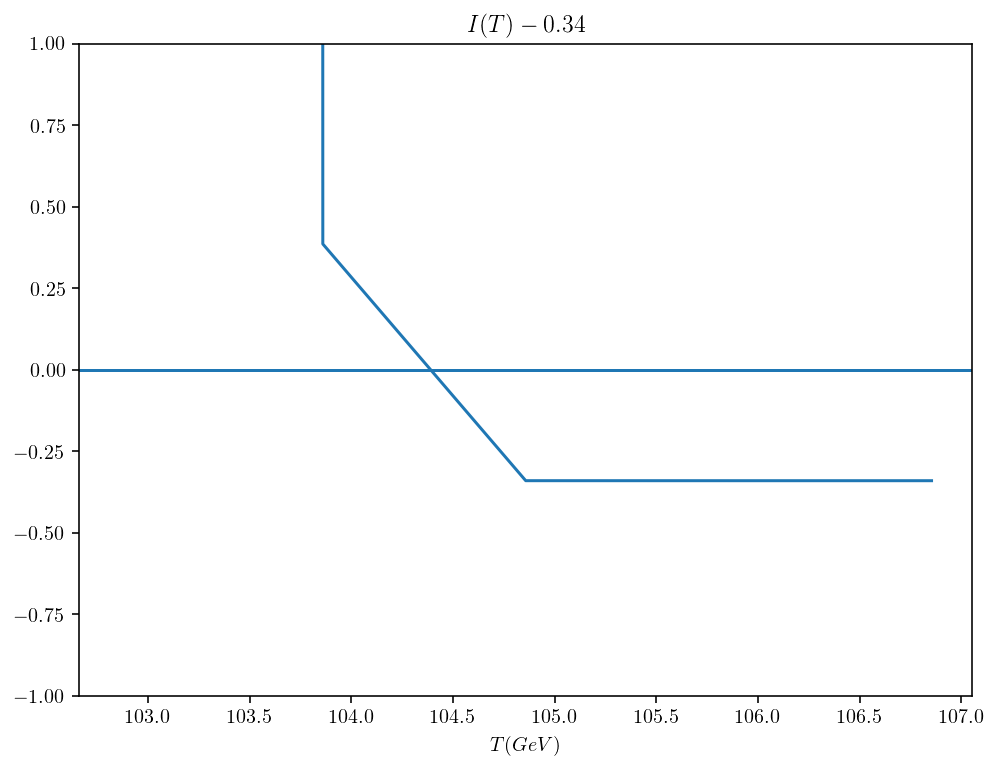

Tunneling from phase 3 to phase 0 at T=104.3906
high_vev = [ 2.20436813e-06 -3.65177298e+00]
low_vev = [ 214.07598463 -129.26088092]
Path deformation converged. 54 steps. fRatio = 1.88551e-02
Path deformation converged. 20 steps. fRatio = 1.80940e-02
Path deformation converged. 8 steps. fRatio = 1.72472e-02
Path deformation converged. 2 steps. fRatio = 1.27671e-02
Path deformation converged. 2 steps. fRatio = 1.27093e-02
Path deformation converged. 2 steps. fRatio = 1.24215e-02
Path deformation converged. 2 steps. fRatio = 1.20106e-02
Path deformation converged. 2 steps. fRatio = 1.13777e-02
Path deformation converged. 2 steps. fRatio = 1.11331e-02
Path deformation converged. 2 steps. fRatio = 1.08116e-02
Path deformation converged. 2 steps. fRatio = 1.06723e-02
Path deformation converged. 2 steps. fRatio = 1.05129e-02
Path deformation converged. 2 steps. fRatio = 1.03321e-02
Path deformation converged. 2 steps. fRatio = 1.01572e-02
Path deformation converged. 2 steps. fRatio = 9.97232

Path deformation converged. 2 steps. fRatio = 1.05136e-02
Path deformation converged. 2 steps. fRatio = 1.03558e-02
Path deformation converged. 2 steps. fRatio = 1.01699e-02
Path deformation converged. 2 steps. fRatio = 9.96900e-03
Path deformation converged. 2 steps. fRatio = 9.76701e-03
Path deformation converged. 2 steps. fRatio = 9.56383e-03
Path deformation converged. 2 steps. fRatio = 9.36250e-03
Path deformation converged. 2 steps. fRatio = 9.16238e-03
Path deformation converged. 2 steps. fRatio = 8.96504e-03
Tunneling from phase 3 to phase 0 at T=104.391
high_vev = [-3.19812019e-06 -3.65181411e+00]
low_vev = [ 214.07555099 -129.26088499]
Path deformation converged. 54 steps. fRatio = 1.88545e-02
Path deformation converged. 20 steps. fRatio = 1.80948e-02
Path deformation converged. 8 steps. fRatio = 1.72518e-02
Path deformation converged. 2 steps. fRatio = 1.26365e-02
Path deformation converged. 2 steps. fRatio = 1.27825e-02
Path deformation converged. 2 steps. fRatio = 1.24827e

In [78]:
df00=pd.read_csv("SCANS/BAU/Z2_breaking_sols_BAU_All.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
df0=pd.read_csv("SCANS/Z2_breaking_no_sols_All.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
df=pd.concat([df00,df0])
df=df[df.vw>0]
df=df.reset_index(drop=True)
df=df[df.vel_converged==False]

modi=np.random.randint(0,len(df))
modi=1
print(modi)


num_points=1
for l in range(num_points):
    ms_val=df.iloc[modi]["ms"]
    theta_val=df.iloc[modi]["theta"]
    u_val=df.iloc[modi]["u"]
    mu3_val=df.iloc[modi]["mu3"]
    muhs_val=df.iloc[modi]["muhs"]
    m=model1(ms = ms_val, theta = theta_val,muhs= muhs_val ,u = u_val,mu3 = mu3_val)

    m.print_couplings()
    thbool=m.theory_consistent()
    EWSBbool=m.isEWSB() 
    Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + 1/4 + m.lammix/24
    Pis=m.lammix/6 + m.lams/4
    lamh_tilde=m.lamh - m.lammix**2/4/m.lams
    dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"muhs":m.muhs,"mu3":m.mu3,
              "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
              "muh2":m.muh2,"mus2":m.mus2,
              "Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde}
    dict_out.update({ "th_bool":thbool and EWSBbool})
    #---------Theoretical consistency
    if dict_out["th_bool"]==False:
        continue
     
    nuc_dicts=find_nucleation(m)
    phases_copy=m.phases.copy()
    if len(nuc_dicts)==0:
        continue
    else:
        num_dicts=len(nuc_dicts)
    dict_out.update({"num_FOPT":num_dicts})    

    for nuc_dict in nuc_dicts: 
        try:
            ###Parameters at nucleation temperature------------------------------------------------------------
            dict_out.update({"Tc_"+str(nuc_dicts.index(nuc_dict)):nuc_dict["Tmax"],
                             "Tmin_"+str(nuc_dicts.index(nuc_dict)):nuc_dict["Tmin"]})
            
            relevant_phases={nuc_dict["high_phase"]:m.phases[nuc_dict["high_phase"]],nuc_dict["low_phase"]:m.phases[nuc_dict["low_phase"]]}
            m.phases=relevant_phases
            #Tnuc=optimize.fminbound(nucleation_temp,nuc_dict["Tmin"],nuc_dict["Tmax"])
            #fun_nucleation=lambda T: (Gamma(T)/Hubble_total(T)**4-1.)**4
            #if nuc_dict["Tmin"]<1:
            #    Tnuc=optimize.fminbound(fun_nucleation,np.mean([nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"]]),nuc_dict["Tmax"])
            #else:
            #    Tnuc=optimize.fminbound(fun_nucleation,nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"])                
            #dict_out.update({'Tnuc_'+str(nuc_dicts.index(nuc_dict)): Tnuc})
            
            #S_nuc=my_Action(Tnuc)
            #dict_out.update({"action_Tn_"+str(nuc_dicts.index(nuc_dict)):S_nuc*Tnuc})
            
            #check_nucleation=abs(Gamma_Hubble4(S_nuc*Tnuc,Tnuc)/Hubble_total(Tnuc)**4-1)<1e-3
            #dict_out.update({"nucleation_bool_"+str(nuc_dicts.index(nuc_dict)):check_nucleation})
            nucleation= findTnuc()
            if nucleation[2]==False:
                m.phases=phases_copy
                continue
            else:
                Tnuc, S_nuc = nucleation[0], nucleation[1]
                dict_out.update({'Tnuc_'+str(nuc_dicts.index(nuc_dict)): Tnuc})
                dict_out.update({"action_Tn_"+str(nuc_dicts.index(nuc_dict)):S_nuc*Tnuc})
                

            m.findAllTransitions(tunnelFromPhase_args={"nuclCriterion":lambda S,T: S/(T+1e-100)-S_nuc})
            alltrans_Tnuc=m.TnTrans
            elem=alltrans_Tnuc[0] ###How many transitions??
            if abs(elem["action"]-S_nuc*Tnuc)>1 and abs(elem["Tnuc"]-Tnuc)>1:
                """check if all transitions indeed find the same S and T values"""
                m.phases=phases_copy
                continue
            dS_TdT_Tnuc=misc.derivative(S_profile, x0=Tnuc, dx=.01, n=1, args=(elem,),order=7)
            
            #--------vevs, energy density, pressure and wall velocity at Tnuc---------------------------------------------------------
            phi_stable_Tnuc=elem["low_vev"]
            dict_out.update({"h_low_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tnuc[0],
                             "s_low_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tnuc[1]})
            
            phi_meta_Tnuc=elem["high_vev"]
            dict_out.update({"h_high_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tnuc[0],
                             "s_high_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tnuc[1]})
            
            Delta_rho_Tnuc=m.energyDensity(phi_meta_Tnuc,Tnuc,include_radiation=True)-m.energyDensity(phi_stable_Tnuc,Tnuc,include_radiation=True)
            dict_out.update({"Delta_rho_Tnuc_"+str(nuc_dicts.index(nuc_dict)): Delta_rho_Tnuc})
            
            Delta_p_Tnuc=m.Vtot(phi_meta_Tnuc,Tnuc)-m.Vtot(phi_stable_Tnuc,Tnuc)
            dict_out.update({"Delta_p_Tnuc_"+str(nuc_dicts.index(nuc_dict)): Delta_p_Tnuc})
            
            alpha_Tnuc=alpha_GW(Tnuc,Delta_rho_Tnuc)
            dict_out.update({"alpha_Tnuc_"+str(nuc_dicts.index(nuc_dict)):alpha_Tnuc})
            
            beta_Tnuc=beta_GW(Tnuc,dS_TdT_Tnuc)
            dict_out.update({"beta_Tnuc_"+str(nuc_dicts.index(nuc_dict)):beta_Tnuc})
            
            xi_Jouguet=((alpha_Tnuc*(2+3*alpha_Tnuc))**0.5+1)/(3**0.5*(1+alpha_Tnuc))
            dV = m.Vtot(phi_meta_Tnuc,Tnuc)-m.Vtot(phi_stable_Tnuc,Tnuc)
            radiationDensity=np.pi**2/30*g_star(Tnuc)*Tnuc**4
            vwall=(dV/alpha_Tnuc/radiationDensity)**0.5 ##Analytic formula
            dict_out.update({"vwall_"+str(nuc_dicts.index(nuc_dict)): vwall,
                             "xi_Jouguet_"+str(nuc_dicts.index(nuc_dict)):xi_Jouguet}) 
            
            my_signal_Tnuc=GW_signal(Tnuc*(1+alpha_Tnuc)**0.25,alpha_Tnuc,beta_Tnuc,1)
            peak_vals_Tnuc=my_signal_Tnuc.T[my_signal_Tnuc[1]==max(my_signal_Tnuc[1])][0] ##Extract values at peak
            f_peak_Tnuc=peak_vals_Tnuc[0]
            Omega_peak_Tnuc=peak_vals_Tnuc[1]
            dict_out.update({"f_peak_Tnuc_"+str(nuc_dicts.index(nuc_dict)): f_peak_Tnuc,
                        "Omega_peak_Tnuc_"+str(nuc_dicts.index(nuc_dict)):Omega_peak_Tnuc})
            #SNR_Tnuc=SNR_GW(Tnuc*(1+alpha_Tnuc)**0.25,alpha_Tnuc,beta_Tnuc,1)
            #dict_out.update({"SNR_Tnuc_"+str(nuc_dicts.index(nuc_dict)): SNR_Tnuc})
            SNR_Tnuc=SNR_GW(my_signal_Tnuc)
            dict_out.update({"SNR_Tnuc_"+str(nuc_dicts.index(nuc_dict)): SNR_Tnuc})
            
            ##Parameters at PERCOLATION temperature Tp-------------------------------------- 
            Tp,volume_shrinks=T_percolation(20,vwall)
            dict_out.update({"Tp_"+str(nuc_dicts.index(nuc_dict)):Tp,
                             "volume_shrinks_"+str(nuc_dicts.index(nuc_dict)):volume_shrinks})
            
            S_p=my_Action(Tp)
            dict_out.update({"action_Tp_"+str(nuc_dicts.index(nuc_dict)):S_p*Tp})
            
            m.findAllTransitions(tunnelFromPhase_args={"nuclCriterion":lambda S,T: S/(T+1e-100)-S_p})
            alltrans_Tp=m.TnTrans
            elem=alltrans_Tp[0] ###How many transitions??
            if abs(elem["action"]-S_p*Tp)>1 and abs(elem["Tnuc"]-Tp)>1:
                """check if all transitions indeed finds the same S and T values"""
                m.phases=phases_copy
                continue
            dS_TdT_Tp=misc.derivative(S_profile, x0=Tp, dx=.01, n=1, args=(elem,),order=7)

            
            #-------vevs, energy density and pressure at Tp--------------------------------
            phi_stable_Tp=elem["low_vev"]
            dict_out.update({"s_low_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tp[1],
                             "h_low_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tp[0]})
            
            phi_meta_Tp=elem["high_vev"]
            dict_out.update({"s_high_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tp[1],
                             "h_high_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tp[0]})
            
            Delta_rho_Tp=m.energyDensity(phi_meta_Tp,Tp,include_radiation=True)-m.energyDensity(phi_stable_Tp,Tp,include_radiation=True)
            dict_out.update({"Delta_rho_Tp_"+str(nuc_dicts.index(nuc_dict)): Delta_rho_Tp})
            
            Delta_p_Tp=m.Vtot(phi_meta_Tp,Tp)-m.Vtot(phi_stable_Tp,Tp)
            dict_out.update({"Delta_p_Tp_"+str(nuc_dicts.index(nuc_dict)): Delta_p_Tp})
            
            alpha_Tp=alpha_GW(Tp,Delta_rho_Tp)
            dict_out.update({"alpha_Tp_"+str(nuc_dicts.index(nuc_dict)):alpha_GW(Tp,Delta_rho_Tp)})
            
            beta_Tp=beta_GW(Tp,dS_TdT_Tp)
            dict_out.update({"beta_Tp_"+str(nuc_dicts.index(nuc_dict)):beta_Tp})
            
            xi_Jouguet_Tp=((alpha_Tp*(2+3*alpha_Tp))**0.5+1)/(3**0.5*(1+alpha_Tp))
            dV_Tp = m.Vtot(phi_meta_Tp,Tp)-m.Vtot(phi_stable_Tp,Tp)
            radiationDensity_Tp=np.pi**2/30*g_star(Tp)*Tp**4
            vwall_Tp=(dV_Tp/alpha_Tp/radiationDensity_Tp)**0.5 ##Analytic formula
            dict_out.update({"vwall_Tp_"+str(nuc_dicts.index(nuc_dict)): vwall_Tp,
                             "xi_Jouguet_Tp_"+str(nuc_dicts.index(nuc_dict)):xi_Jouguet_Tp})
            
            my_signal_Tp=GW_signal(Tp*(1+alpha_Tp)**0.25,alpha_Tp,beta_Tp,1)
            peak_vals_Tp=my_signal_Tp.T[my_signal_Tp[1]==max(my_signal_Tp[1])][0] ##Extract values at peak
            f_peak_Tp=peak_vals_Tp[0]
            Omega_peak_Tp=peak_vals_Tp[1]
            dict_out.update({"f_peak_Tp_"+str(nuc_dicts.index(nuc_dict)): f_peak_Tp,
                             "Omega_peak_Tp_"+str(nuc_dicts.index(nuc_dict)):Omega_peak_Tp})
            #SNR_Tp=SNR_GW(Tp*(1+alpha_Tp)**0.25,alpha_Tp,beta_Tp,vwall)
            SNR_Tp=SNR_GW(my_signal_Tp)
            dict_out.update({"SNR_Tp_"+str(nuc_dicts.index(nuc_dict)): SNR_Tp})
            
            #-----Fill dictionary------------------------------------------------------------
            print("\n ..........\n Current dictionary is: \n")
            print(dict_out)
        except:
            print("error ocurred")
            m.phases=phases_copy
            continue

In [79]:
# ##Plot the nucleation rate and Hubble constant as function of Temperature
# Temp_range=np.linspace(nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"])
# H_tot=[]
# Gam=[]
# for Ti in Temp_range:
#     H_tot.append(Hubble_total(Ti)**4)
#     Gam.append(Gamma(Ti))
# 
# thick_size=16
# label_size=20
# plt.plot(Temp_range,Gam,label="$\\Gamma(T)$")
# plt.plot(Temp_range,Hubble_radiation(Temp_range)**4,label="$H_{radiation}^4$")
# plt.plot(Temp_range,H_tot,linestyle="--",label="$H_{total}^4$")
# plt.legend()
# plt.yscale("log")
# plt.xlabel("$T$ (GeV)",size=label_size)
# plt.xticks(fontsize=thick_size)
# plt.yticks(fontsize=thick_size)
# plt.title("Benchmark P1",size=label_size)
# #plt.grid(True)
# plt.legend(prop={'size': label_size})
# #plt.legend(prop={'size': label_size})
# plt.tight_layout()
# #plt.savefig('SCANS/bubble_PLOTS/Nucleation_False.pdf', dpi=300)
# plt.show()

In [80]:
nuc_dicts

[{'Tmin': 160.3236597394811,
  'Tmax': 160.36885808235886,
  'high_phase': 1,
  'low_phase': 0},
 {'Tmin': 87.9005382402787,
  'Tmax': 129.18292002322028,
  'high_phase': 3,
  'low_phase': 0}]

In [81]:
dict_out

{'ms': 187.00623674472027,
 'theta': 0.1888629592079408,
 'u': -128.6009990971809,
 'muhs': 122.84087384237318,
 'mu3': -869.3317232448068,
 'lamh': 0.13469247165101286,
 'lams': 3.5414159926157462,
 'lammix': 1.0677554717498818,
 'muh2': 1196.2354659498742,
 'mus2': -49817.26133462385,
 'Pih': 0.446337529060495,
 'Pis': 1.0633132434455836,
 'lamh_tilde': 0.05420900473911561,
 'th_bool': True,
 'num_FOPT': 2,
 'Tc_0': 160.36885808235886,
 'Tmin_0': 160.3236597394811,
 'Tc_1': 129.18292002322028,
 'Tmin_1': 87.9005382402787,
 'Tnuc_1': 106.85273267088705,
 'action_Tn_1': 16083.335063049588,
 'h_low_Tnuc_1': 211.30012855975025,
 's_low_Tnuc_1': -129.2941041428195,
 'h_high_Tnuc_1': -2.660244520125315e-05,
 's_high_Tnuc_1': -3.910289088504701,
 'Delta_rho_Tnuc_1': 63748046.49442807,
 'Delta_p_Tnuc_1': 28413634.23749125,
 'alpha_Tnuc_1': 0.014528775601642268,
 'beta_Tnuc_1': 1171.7330057757351,
 'vwall_1': 0.6676209438737096,
 'xi_Jouguet_1': 0.6671408730902827,
 'f_peak_Tnuc_1': 0.0111950

In [82]:
df.iloc[modi].Type,df.iloc[modi].vw

('Detonation', 0.6689774847524387)

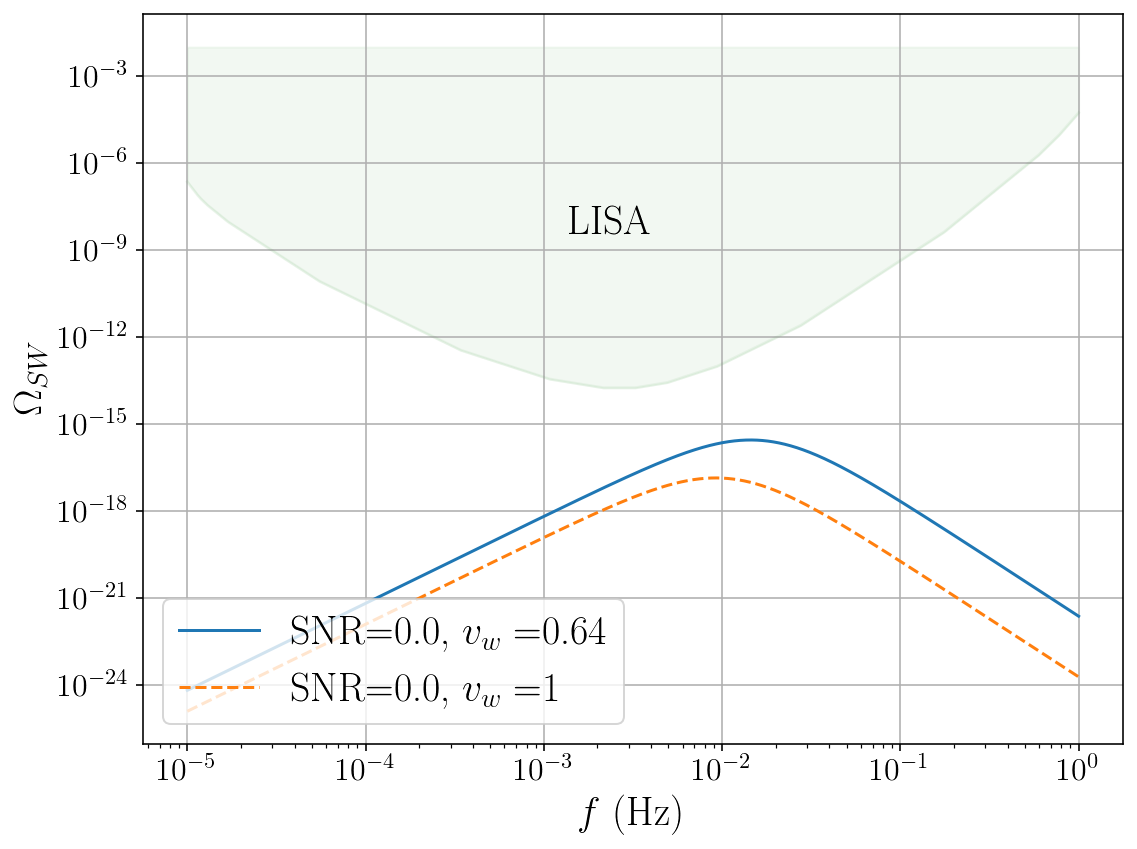

In [33]:

###Obtained from 
#df=pd.read_csv("SCANS/BAU/Z2_breaking_sols_BAU_All.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
#df=df[df.num_FOPT>1]


Temp, alpha, beta, vel=dict_out["Tp_0"],dict_out["alpha_Tp_0"],dict_out["beta_Tp_0"],df.iloc[modi].vw
my_signal=GW_signal(Temp, alpha, beta, vel)
SNR=SNR_GW(my_signal)
Temp, alpha, beta, vel1=dict_out["Tp_0"],dict_out["alpha_Tp_0"],dict_out["beta_Tp_0"],1
my_signal_1=GW_signal(Temp, alpha, beta, vel1)
SNR_1=SNR_GW(my_signal_1)

thick_size=16
label_size=20

plt.plot(my_signal[0],my_signal[1],
         label= "SNR="+str(np.round(SNR,2))+", $v_w=$" +str(np.round(vel,2)))
plt.plot(my_signal_1[0],my_signal_1[1],linestyle="--",
         label="SNR="+str(np.round(SNR_1,2))+ ", $v_w=$"+str(np.round(vel1,2)))
plt.plot(LISA_curve.f,LISA_curve.Omega_lim,alpha=0.05,color="g")
plt.fill_between(LISA_curve.f, LISA_curve.Omega_lim, 1e-2, alpha=0.05,color="g")
plt.figtext(.5, .72, "LISA", fontsize=label_size)

plt.xlabel("$f$ (Hz)",size=label_size)
plt.ylabel("$\\Omega_{SW}$",size=label_size)
plt.xscale("log")
plt.yscale("log")           
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend(loc="lower left",prop={'size': label_size})
#plt.title("Benchmark P2",size=label_size)



#plt.legend(prop={'size': label_size})
plt.tight_layout()
#plt.savefig('SCANS/bubble_PLOTS/GW_spectum_P2.pdf', dpi=300)
plt.show()

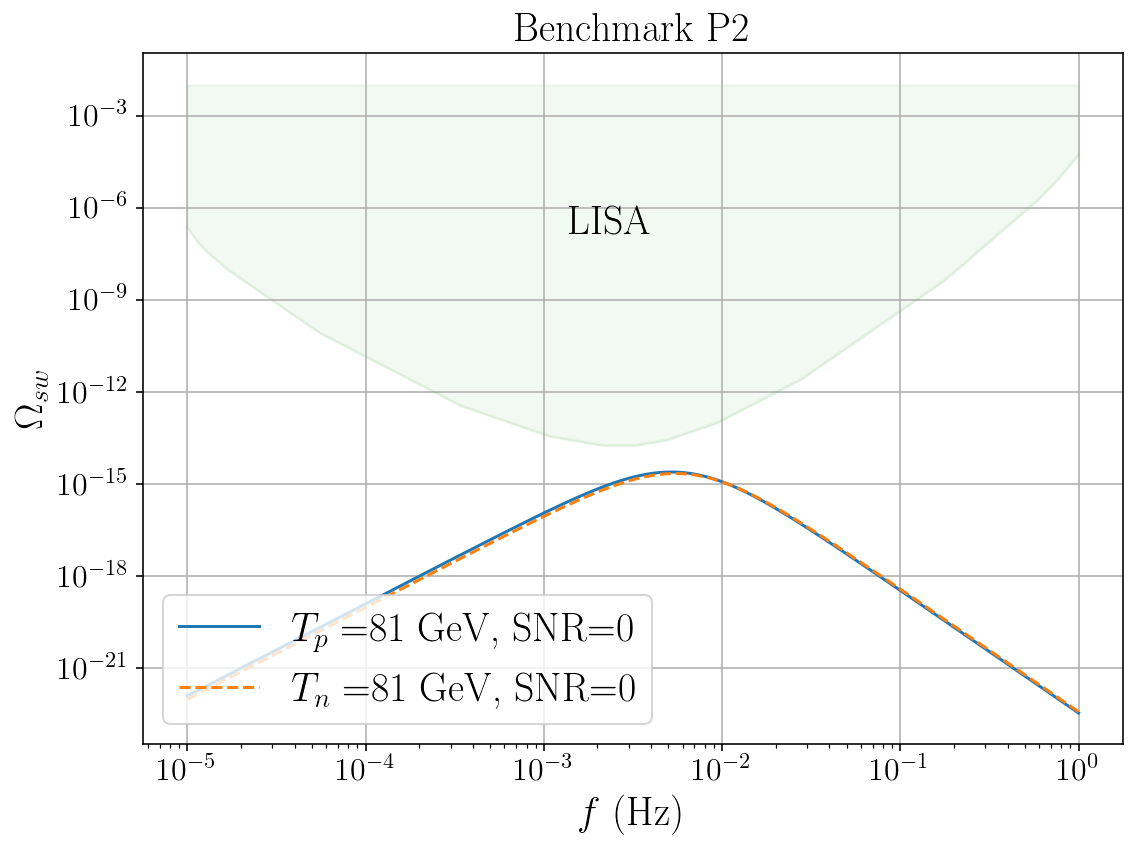

In [40]:
Temp, alpha, beta, vel=dict_out["Tp_0"],dict_out["alpha_Tp_0"],dict_out["beta_Tp_0"],dict_out["vwall_Tp_0"]
my_signal=GW_signal(Temp, alpha, beta, vel)
Temp, alpha, beta, vel=dict_out["Tnuc_0"],dict_out["alpha_Tnuc_0"],dict_out["beta_Tnuc_0"],dict_out["vwall_0"]
my_signal_1=GW_signal(Temp, alpha, beta, vel)

thick_size=16
label_size=20

plt.plot(my_signal[0],my_signal[1],
         label="$T_p=$"+str(int(np.round(dict_out["Tp_0"])))+" GeV" + ", SNR="+str(int(np.round(dict_out["SNR_Tp_0"]))))
plt.plot(my_signal_1[0],my_signal_1[1],linestyle="--",
         label="$T_n=$"+str(int(np.round(dict_out["Tnuc_0"])))+" GeV" ", SNR="+ str(int(np.round(dict_out["SNR_Tnuc_0"]))))
plt.plot(LISA_curve.f,LISA_curve.Omega_lim,alpha=0.05,color="g")
plt.fill_between(LISA_curve.f, LISA_curve.Omega_lim, 1e-2, alpha=0.05,color="g")
plt.figtext(.5, .72, "LISA", fontsize=label_size)

plt.xlabel("$f$ (Hz)",size=label_size)
plt.ylabel("$\\Omega_{sw}$",size=label_size)
plt.xscale("log")
plt.yscale("log")           
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend(loc="lower left",prop={'size': label_size})
plt.title("Benchmark P2",size=label_size)



#plt.legend(prop={'size': label_size})
plt.tight_layout()
#plt.savefig('SCANS/bubble_PLOTS/GW_spectum_P2.pdf', dpi=300)
plt.show()